# CosmoDC

### Goals
- How to interface QP and sacc
- How to create n(z) uncertainties from an ensemble of n(z)'s

### Requirements
- **A sacc file**: we will use the sacc file of Prat et al 2022 (2212.09345). This sacc file contains the summary statistics measured from the CosmoDC2 simulations using the DESC TXPipe pipeline. The summary statistics include the angular power spectra of the shear-shear, position-shear, and position-position correlations, as well as the cross-correlations between the different probes. The sacc file also contains the redshift distributions of the galaxies in the simulations. For more details see Prat et al 2022. The data can found in NERSC at '/global/cfs/cdirs/lsst/groups/WL/projects/star-challenge/gaussian/data_vectors'.

- **A series of QP ensenbles**: For this tutorials I have created a series of QP ensembles using the cosmoDC2_v1.1.4_image_with_photoz_v1 simulations. This catalog contains photometric redshifts that were computed with the `BPZ` template-based code (https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract) by Sam Schmidt. We use all the available pixels and impose a 24.1 magnitude cut in the i-band following Prat et al. The edges of the tomographic bins are also taken from Prat et al.

### Special Dependencies
- **sacc**: standard DESC library to load and save data.
- **nz_prior**: this very own library, used to compute n(z) uncertainties from n(z) ensembles.
- **PACC** is a plotting library (https://github.com/jaimerzpP/pacc) for sacc files.

In [1]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as stats
import qp
import sacc
import yaml
import scipy
import nz_prior as nzp

In [2]:
def concatenate_npz_files(file_paths):
    concatenated_data = {}
    
    for file_path in file_paths:
        data = np.load(file_path)
        for key in data.files:
            if key in concatenated_data:
                if key == "photo_hists":
                    concatenated_data[key] = np.concatenate((concatenated_data[key].T, data[key].T), axis=0).T
            else:
                concatenated_data[key] = data[key]
    
    return concatenated_data

method = "bpz"
shears_0_paths = []
shears_1_paths = []
shears_2_paths = []
shears_3_paths = []
shears_4_paths = []

lens_0_paths = []
lens_1_paths = []
lens_2_paths = []
lens_3_paths = []
lens_4_paths = []

for i in range(4, 5+1):
    shears_0_paths.append(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}_{i}/shear_0.npz")
    shears_1_paths.append(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}_{i}/shear_1.npz")
    shears_2_paths.append(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}_{i}/shear_2.npz")
    shears_3_paths.append(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}_{i}/shear_3.npz")
    shears_4_paths.append(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}_{i}/shear_4.npz")

    lens_0_paths.append(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}_{i}/lens_0.npz")
    lens_1_paths.append(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}_{i}/lens_1.npz")
    lens_2_paths.append(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}_{i}/lens_2.npz")
    lens_3_paths.append(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}_{i}/lens_3.npz")
    lens_4_paths.append(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}_{i}/lens_4.npz")

source_0 = concatenate_npz_files(shears_0_paths)
source_1 = concatenate_npz_files(shears_1_paths)
source_2 = concatenate_npz_files(shears_2_paths)
source_3 = concatenate_npz_files(shears_3_paths)
source_4 = concatenate_npz_files(shears_4_paths)

lens_0 = concatenate_npz_files(lens_0_paths)
lens_1 = concatenate_npz_files(lens_1_paths)
lens_2 = concatenate_npz_files(lens_2_paths)
lens_3 = concatenate_npz_files(lens_3_paths)
lens_4 = concatenate_npz_files(lens_4_paths)

### Load Data

In [3]:
def nz_interpolate(source, n):
    # Extract the zgrid and photo_hists from source_0
    znodes = source['znodes']
    photo_hists = source['photo_hists']
    dz = znodes[1] - znodes[0]

    # Create an interpolation function
    print(znodes.shape, photo_hists.shape)
    interp_func = interp1d(znodes, photo_hists, kind='cubic', axis=0)

    # Define the new zgrid with 1000 nodes
    new_znodes = np.linspace(znodes.min(), znodes.max(), n)
    new_dz = new_znodes[1] - new_znodes[0]
    new_zgrid = np.append([new_znodes[0] - new_dz/2], new_znodes + new_dz/2)

    # Interpolate the photo_hists to the new zgrid
    new_photo_hists = interp_func(new_znodes)
    new_source = {'znodes': new_znodes, 
                  'zgrid': new_zgrid,
                  'photo_hists': new_photo_hists}
    return new_source

In [4]:
# Sacc file
s = sacc.Sacc.load_fits("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc")
y = yaml.load(open("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/gcgc_gcwl_wlwl.yml"), Loader=yaml.FullLoader)

# Interpolated nz
#source_0 = nz_interpolate(source_0, 1000)
#source_1 = nz_interpolate(source_1, 1000)
#source_2 = nz_interpolate(source_2, 1000)
#source_3 = nz_interpolate(source_3, 1000)
#source_4 = nz_interpolate(source_4, 1000)

#lens_0 = nz_interpolate(lens_0, 1000)
#lens_1 = nz_interpolate(lens_1, 1000)
#lens_2 = nz_interpolate(lens_2, 1000)
#lens_3 = nz_interpolate(lens_3, 1000)
#lens_4 = nz_interpolate(lens_4, 1000)

tomos = {'source_0': source_0,
        'source_1': source_1,
        'source_2': source_2,
        'source_3': source_3,
        'source_4': source_4,
        'lens_0': lens_0,
        'lens_1': lens_1,
        'lens_2': lens_2,
        'lens_3': lens_3,
        'lens_4': lens_4}

crosscorrs_method = "BinWise"

In [5]:
#cle = pacc.ClsEnsemble(s, y, label="CosmoDC2")
#pacc.plot_cls([cle], cle.pairs)

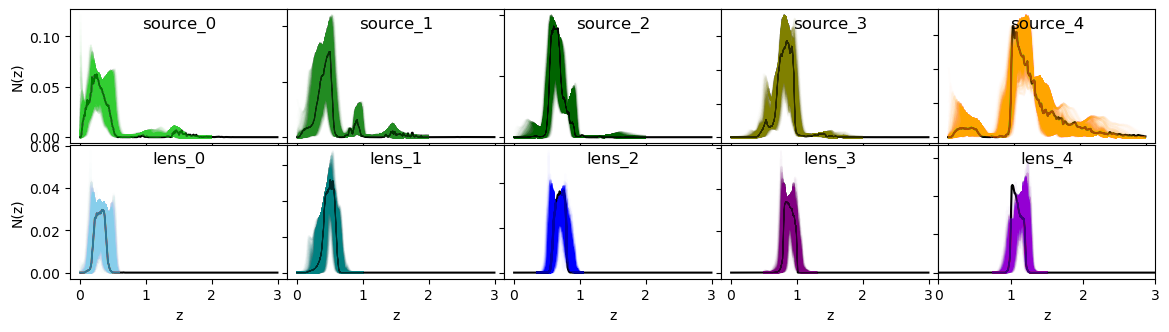

In [6]:
figure, axis = plt.subplots(2, 5, figsize=(14, 3.5))
figure.subplots_adjust(wspace=0, hspace=0.01)

colors = ['limegreen', 'forestgreen', 'darkgreen', 'olive', 'orange']
lens_keys = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    spec = s.tracers[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(spec.z))
    alpha = photo_dz/spec_dz
    norm = np.sum(np.mean(tomo['photo_hists'], axis=1))
    axis[0, i].plot(spec.z, alpha*spec.nz, 'k-')
    axis[0, i].plot(tomo['znodes'], tomo['photo_hists']/norm, '-', color=colors[i], alpha=0.01)
    #axis[0].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    axis[0, i].set_title(key, y=0.8)
    axis[0, i].set_xlabel('z')
    if i == 0:
        axis[0, i].set_ylabel('N(z)')

colors = ['skyblue', 'teal', 'blue', 'purple', 'darkviolet']
lens_keys = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    spec = s.tracers[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(spec.z))
    alpha = photo_dz/spec_dz
    norm = np.sum(np.mean(tomo['photo_hists'], axis=1))
    axis[1, i].plot(spec.z, alpha*spec.nz, 'k-')
    axis[1, i].plot(tomo['znodes'], tomo['photo_hists']/norm, '-', color=colors[i], alpha=0.01)
    #axis[1].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    axis[1, i].set_title(key, y=0.8)
    axis[1, i].set_xlabel('z')
    if i == 0:
        axis[0, i].set_ylabel('N(z)')
        axis[1, i].set_ylabel('N(z)')
    else:
        axis[0, i].set_yticklabels([])
        axis[1, i].set_yticklabels([])

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")

plt.xlim([0.0, 3.0])
plt.show()

In [7]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        tomo = tracers_dict[key]
        nzs = tomo['photo_hists']
        zs = tomo['znodes']
        norms = np.sum(nzs, axis=0)
        axis[0,i].plot(zs, nzs/norms, 'k-', alpha=0.01)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_ylim([-0.001, 0.1])
        axis[0,i].set_title(key)
        if i == 0:
            axis[0,i].set_ylabel(r'$p(z)$')
        else:
            axis[0,i].set_yticklabels([])
            axis[1,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

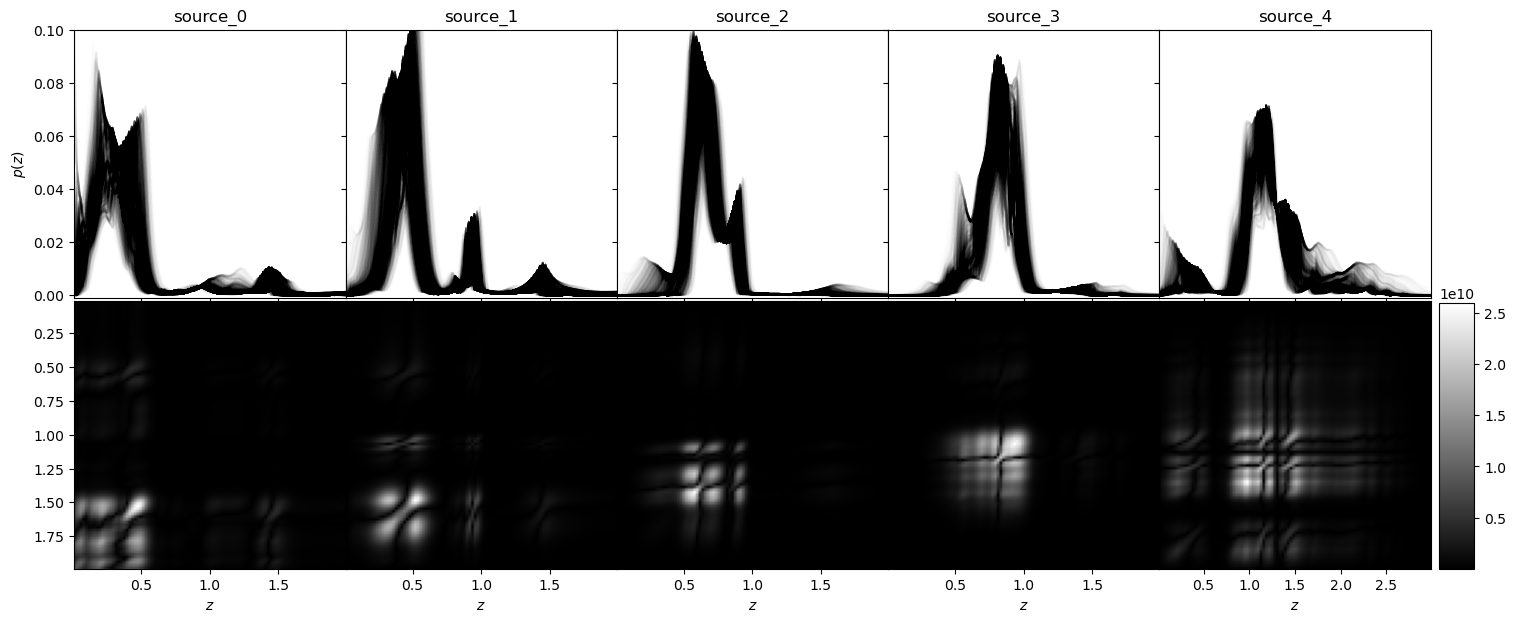

In [8]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(tomos, plot_tracers)

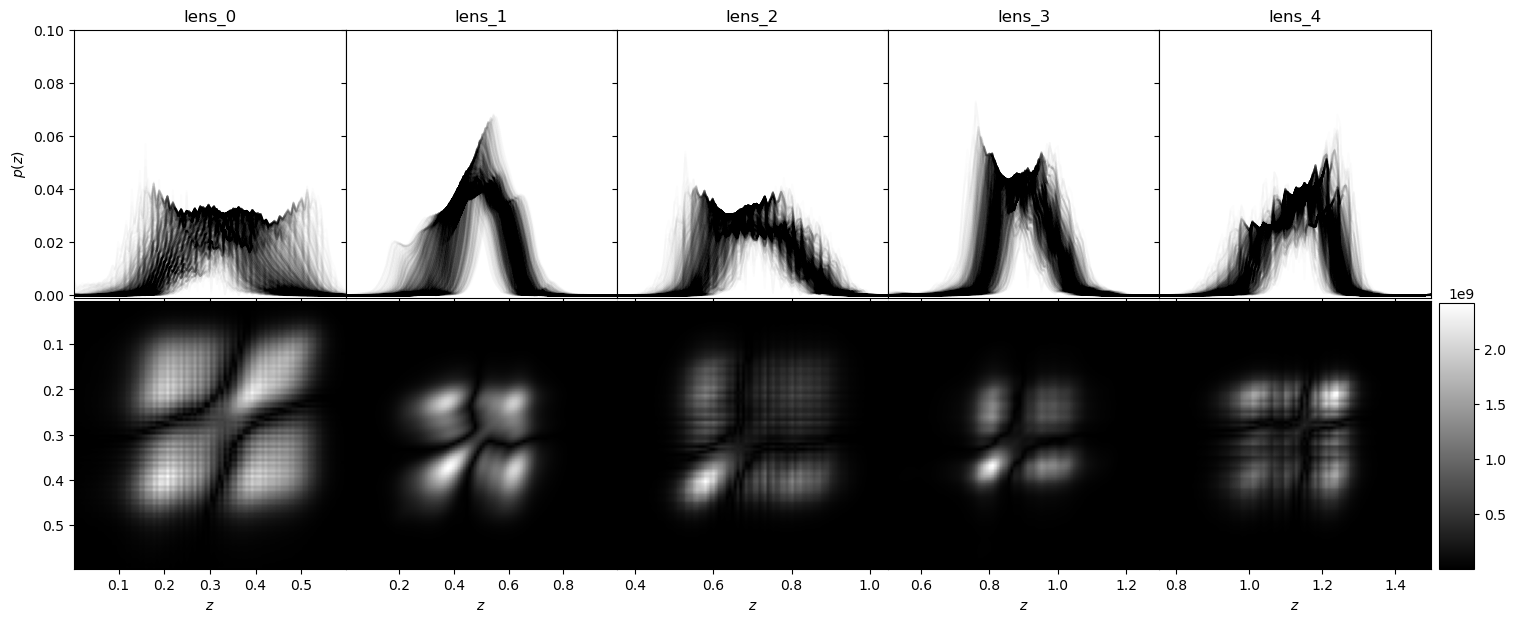

In [9]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(tomos, plot_tracers)

# Interfacing SACC and QP

In [10]:
def make_qp(ens):
    pzs = ens['photo_hists'].T
    zs_edges = ens['zgrid']
    return qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":pzs})

def update_sacc_qp(s, enss):
    ss = s.copy()
    tracers = ss.tracers
    if tracers.keys() != enss.keys():
        raise ValueError("Tracers in sacc file and ensembles do not match")
    for key in tracers.keys():
        ens = enss[key]
        q = make_qp(ens)
        ss.add_tracer('Qpnz', key, q)
    return ss

ss_qp = update_sacc_qp(s, tomos)

# Computing Uncertainties

Now we are just going to apply the methods of nz_prior described in the basic tutorial for each of the tracers in the sacc file. For the sake of brevity we will only use the qp tracers but the same can be done for the NZTracers.

In [11]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        zs, nzs = tracers_dict[key]
        nzs = nzs.T
        axis[0,i].plot(zs, nzs, 'k-', alpha=0.01)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        #axis[0,i].errorbar(zs, nz_mean, yerr=np.sqrt(np.diag(cov)), fmt='k-')
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_title(key)
        axis[0,i].set_ylim([-0.001, 0.1])
        if i == 0:
            axis[0,i].set_ylabel(r'$p(z)$')
        else:
            axis[0,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

## Shifts

In [12]:
shifts_priors = nzp.PriorSacc(ss_qp, 
                            model="Shifts",
                            compute_crosscorrs="Full")

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


In [13]:
import scipy.stats

scipy.stats.mode(shifts_priors.model_objs["lens_0"].nzs)[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.47359862e-05, 2.42873409e-05,
       2.66127247e-05, 1.14097549e-04, 3.59142595e-05, 3.18920875e-05,
       1.24905613e-04, 7.63061215e-05, 1.07087235e-04, 8.47520197e-05,
       1.41829040e-04, 1.66124358e-04, 2.11317491e-04, 5.04374258e-04,
       7.13892798e-04, 6.14246792e-04, 1.41437923e-03, 1.13505312e-03,
       1.80189033e-03, 4.10035471e-03, 4.15349065e-03, 2.24081640e-02,
       8.92223891e-03, 1.27247204e-02, 1.09240666e-02, 1.19901490e-02,
       1.65331027e-02, 1.71594325e-02, 1.52265632e-02, 1.47253972e-02,
       1.47634899e-02, 1.47455516e-02, 2.24982091e-02, 2.30791724e-02,
       2.57373415e-02, 2.31126472e-02, 3.20074461e-02, 2.05513249e-02,
       6.30600165e-03, 5.34509233e-03, 3.20353789e-02, 2.04874297e-02,
       4.21278355e-03, 2.08457308e-03, 2.75262010e-02, 2.30762576e-02,
      

Removed no burn in
Removed no burn in


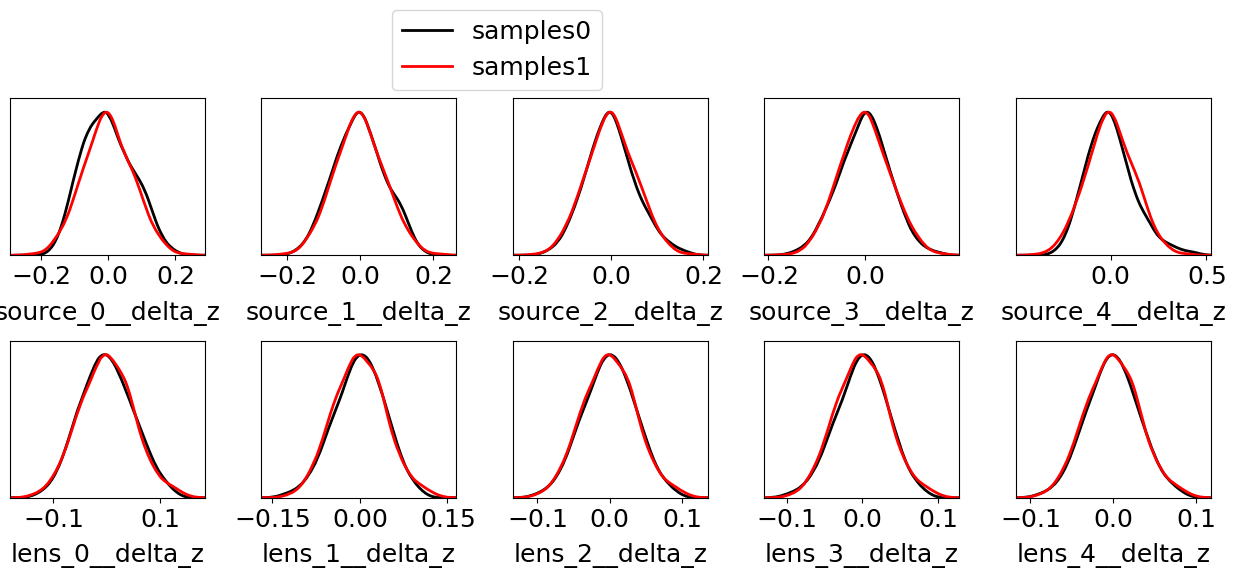

In [14]:
shifts_priors.plot_prior(mode="1D", add_prior=True, nx=5, lws=2)

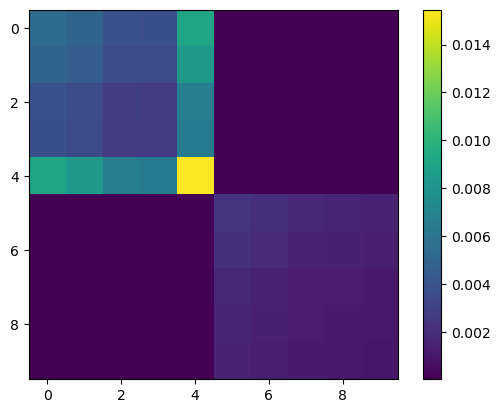

In [15]:
mean, cov, chol = shifts_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(cov)
plt.colorbar()

In [16]:
mean, cov, chol = shifts_priors.get_prior()
file_name = "dz_prior.npz"
save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_dz_{}_priors/".format(method) + file_name
np.savez(save_to, mean=mean, cov=cov, chol=chol)

In [17]:
shifted_nzs = {}
for i in range(500):
    prior_sample = shifts_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = shifts_priors.model_objs[tracer_name]
        nz_fid = [model_obj.z, model_obj.nz_mean]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = [prior_sample[nz_name] for nz_name in nz_names]
        shifted_nz = nzp.shift_model(nz_fid, params[0])[1]
        if i == 0:
            shifted_nzs[tracer_name] = [nz_fid[0], shifted_nz]
        else:

            shifted_nzs[tracer_name] = [nz_fid[0], np.vstack([shifted_nzs[tracer_name][1], shifted_nz])]


In [18]:
_shifted_nzs = {}
for i in range(2000):
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = shifts_priors.model_objs[tracer_name]
        nz_fid = [model_obj.z, model_obj.nz_mean]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = model_obj.params[0][i]
        shifted_nz = nzp.shift_model(nz_fid, params)[1]
        if i == 0:
            _shifted_nzs[tracer_name] = [nz_fid[0], shifted_nz]
        else:

            _shifted_nzs[tracer_name] = [nz_fid[0], np.vstack([shifted_nzs[tracer_name][1], shifted_nz])]

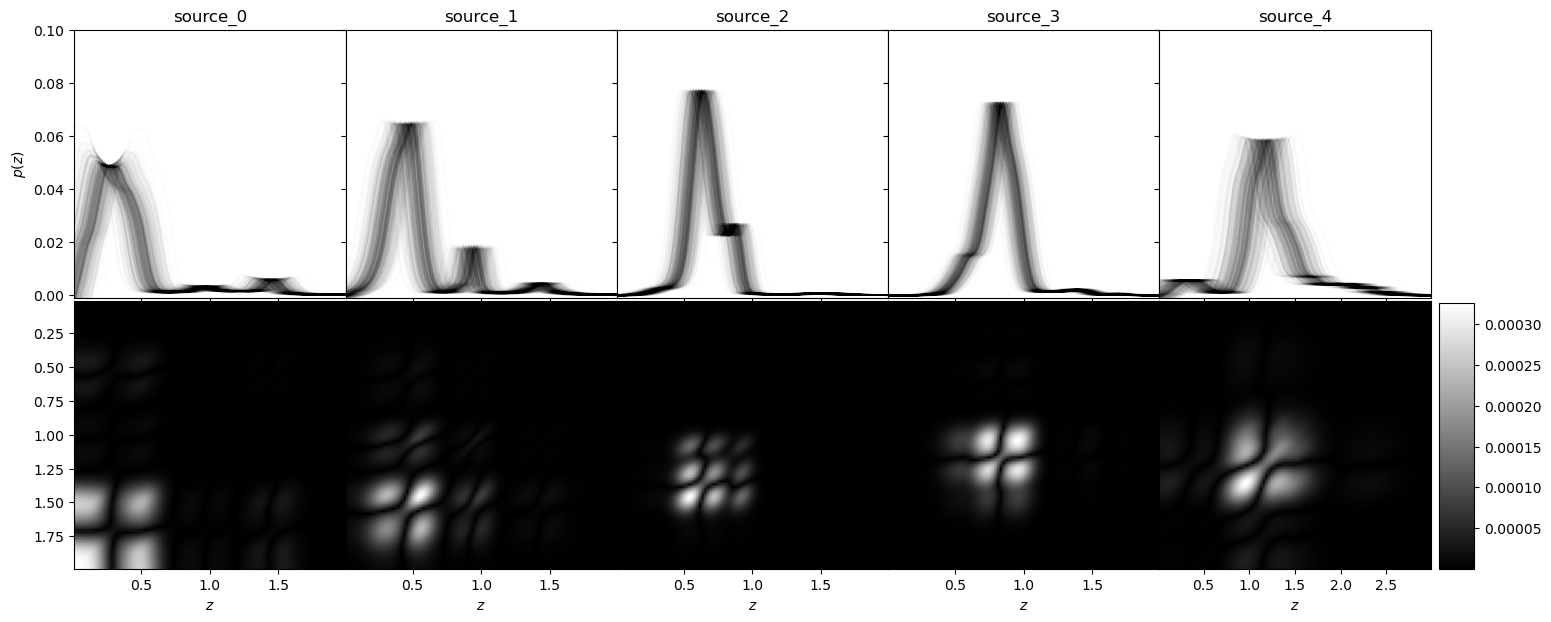

In [19]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(shifted_nzs, plot_tracers)

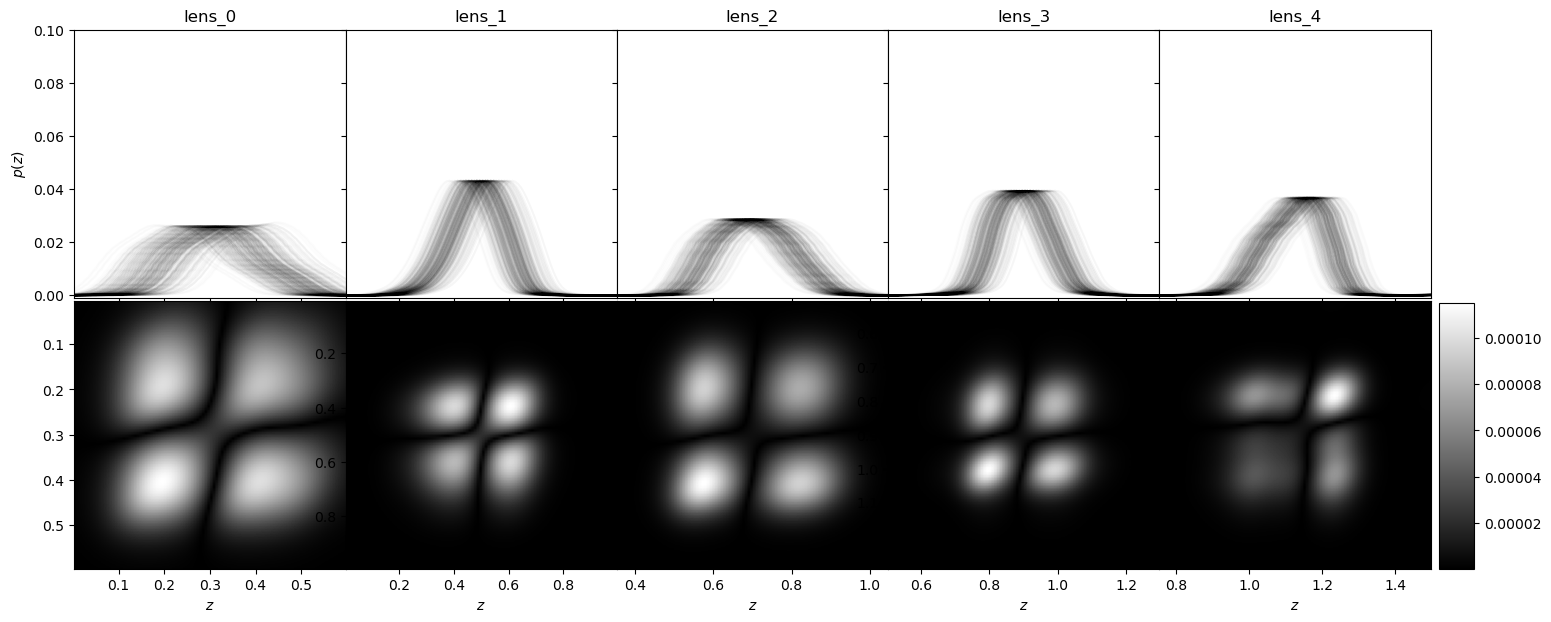

In [20]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(shifted_nzs, plot_tracers)

In [21]:
shifts_var_comp = {}
_shifts_var_comp = {}
for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = shifts_priors.model_objs[tracer_name]
        shifted_nzs_i = shifted_nzs[tracer_name]
        cov = np.cov(shifted_nzs_i[1].T)
        _cov = np.cov(_shifted_nzs[tracer_name][1].T)
        __cov = model_obj.nz_cov
        errs = np.sqrt(np.diag(cov))
        _errs = np.sqrt(np.diag(_cov))
        __errs = np.sqrt(np.diag(__cov))
        shifts_var_comp[tracer_name] = [shifted_nzs_i[0],  (errs-__errs)/__errs]
        _shifts_var_comp[tracer_name] = [shifted_nzs_i[0],  (_errs-__errs)/__errs]


In [22]:
#shifts_Ds = {}
#for tracer_name in shifted_nzs.keys():
#    model_obj = shifts_priors.model_objs[tracer_name]
#    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
#    nzs = shifted_nzs[tracer_name][1]
#    mu_2 = np.mean(nzs, axis=0)
#    K_2 = np.cov(nzs.T)
#    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
#    shifts_Ds[tracer_name] = np.abs(D)

## Shifts & widths

In [23]:
SnWs_priors = nzp.PriorSacc(ss_qp, 
                            model="ShiftsWidths",
                            compute_crosscorrs="Full")

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


In [24]:
SnWs_priors.model_objs["lens_0"]

Removed no burn in
Removed no burn in


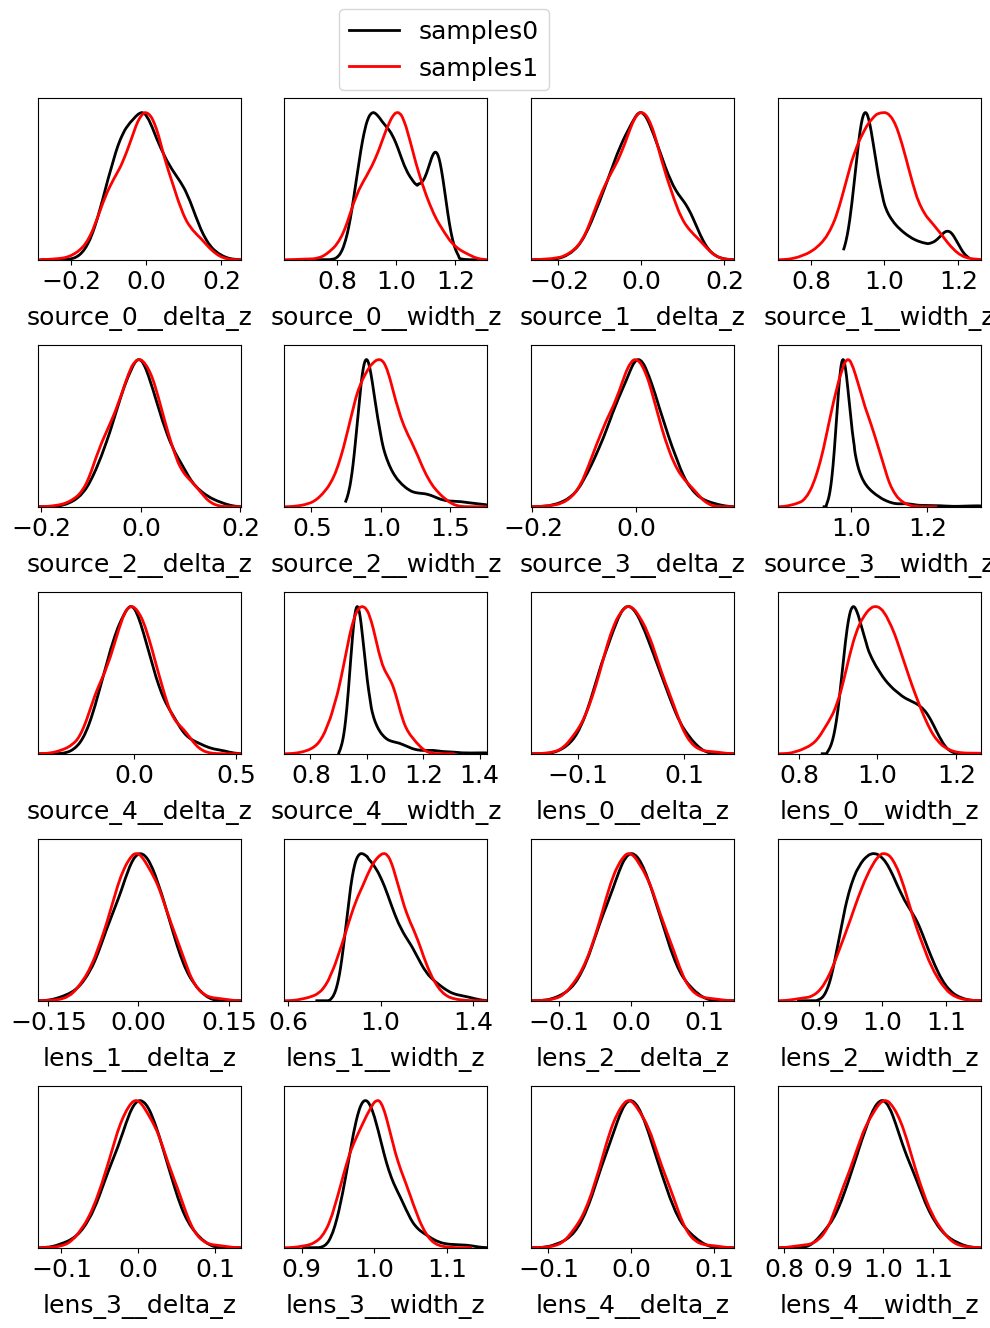

In [25]:
SnWs_priors.plot_prior(mode="1D", add_prior=True, nx=4, lws=2)

In [26]:
mean, cov, chol = SnWs_priors.get_prior()
file_name = "wzdz_prior.npz"
save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_wzdz_{}_priors/".format(method) + file_name
np.savez(save_to, mean=mean, cov=cov, chol=chol)


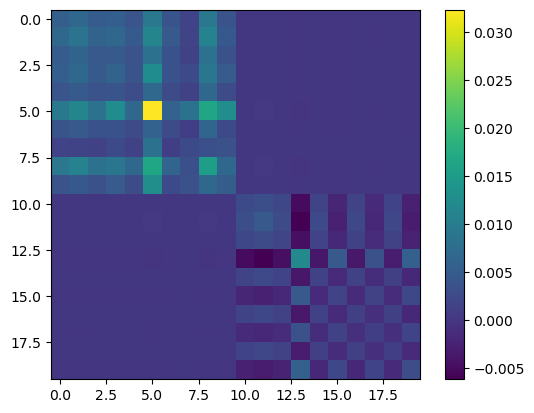

In [27]:
mean, cov, chol = SnWs_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(cov)
plt.colorbar()

In [28]:
SnWs_nzs = {}
for i in range(500):
    prior_sample = SnWs_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = SnWs_priors.model_objs[tracer_name]
        nz_fid = [model_obj.z, model_obj.nz_mean]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = [prior_sample[nz_name] for nz_name in nz_names]
        shifted_nz = nzp.shift_and_width_model(nz_fid, params)[1]
        if i == 0:
            SnWs_nzs[tracer_name] = [nz_fid[0], shifted_nz]
        else:

            SnWs_nzs[tracer_name] = [nz_fid[0], np.vstack([SnWs_nzs[tracer_name][1], shifted_nz])]

In [29]:
_SnWs_nzs = {}
for i in range(2000):
    prior_sample = SnWs_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = SnWs_priors.model_objs[tracer_name]
        nz_fid = [model_obj.z, model_obj.nz_mean]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = model_obj.params.T[i]
        shifted_nz = nzp.shift_and_width_model(nz_fid, params)[1]
        if i == 0:
            _SnWs_nzs[tracer_name] = [nz_fid[0], shifted_nz]
        else:

            _SnWs_nzs[tracer_name] = [nz_fid[0], np.vstack([SnWs_nzs[tracer_name][1], shifted_nz])]


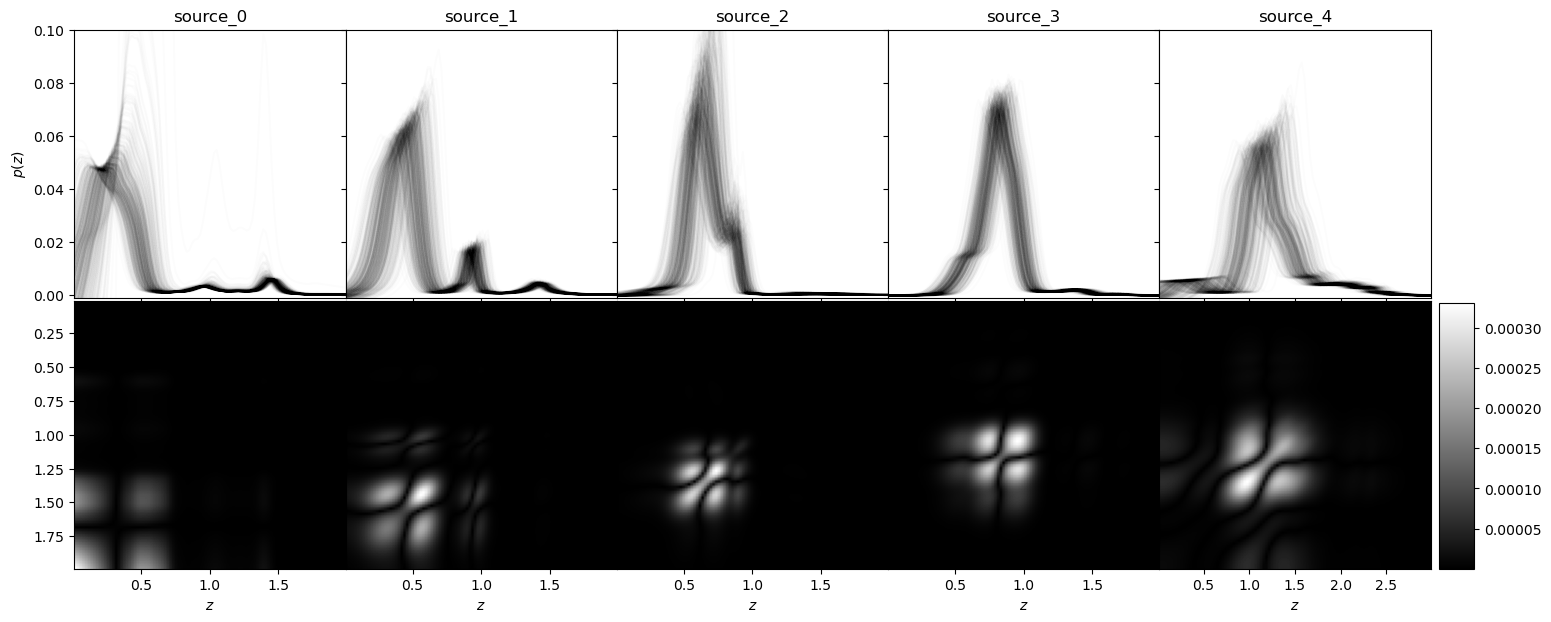

In [30]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(SnWs_nzs, plot_tracers)

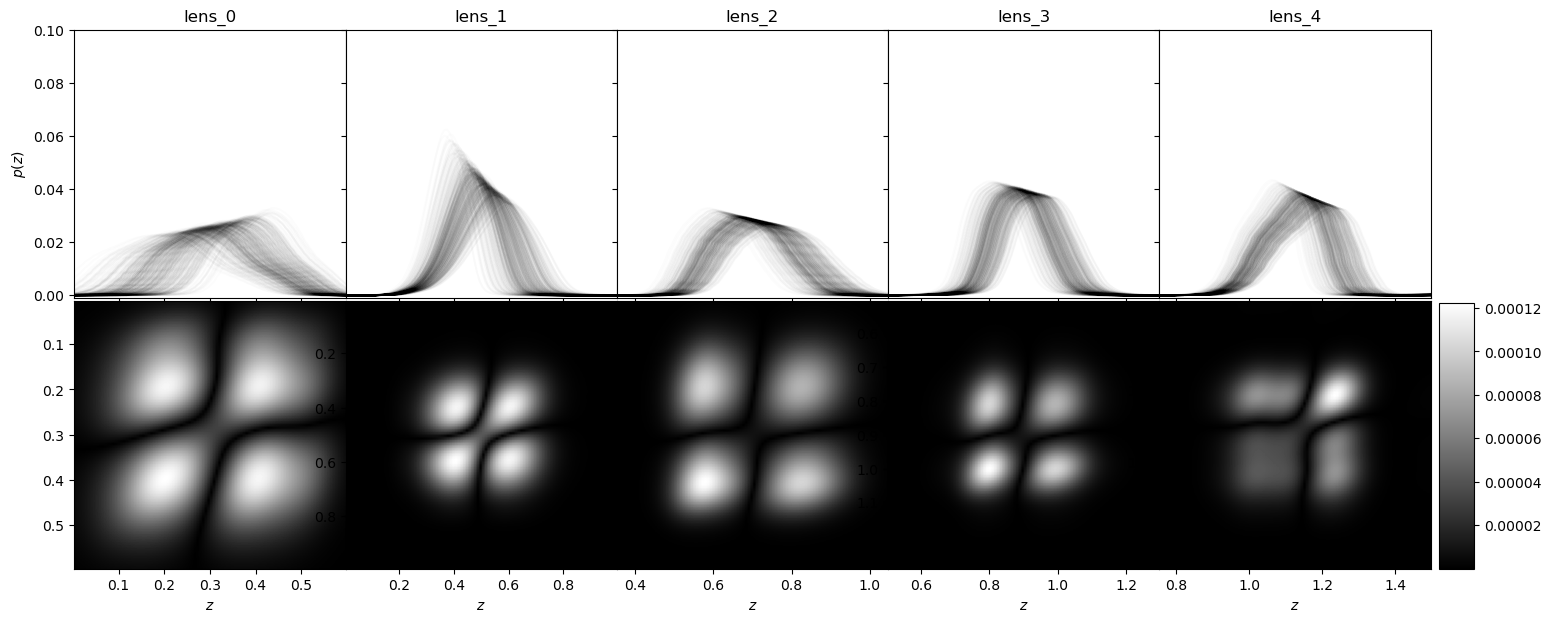

In [31]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(SnWs_nzs, plot_tracers)

In [32]:
SnWs_var_comp = {}
_SnWs_var_comp = {}
for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = SnWs_priors.model_objs[tracer_name]
        shifted_nzs_i = SnWs_nzs[tracer_name]
        _shifted_nzs_i = _SnWs_nzs[tracer_name]
        cov = np.cov(shifted_nzs_i[1].T)
        _cov = np.cov(_shifted_nzs_i[1].T)
        __cov = model_obj.nz_cov
        errs = np.sqrt(np.diag(cov))
        _errs = np.sqrt(np.diag(_cov))
        __errs = np.sqrt(np.diag(__cov))
        SnWs_var_comp[tracer_name] = [shifted_nzs_i[0],  (errs-__errs)/__errs]
        _SnWs_var_comp[tracer_name] = [shifted_nzs_i[0],  (_errs-__errs)/__errs]

In [33]:
#SnWs_Ds = {}
#for tracer_name in SnWs_nzs.keys():
#    model_obj = SnWs_priors.model_objs[tracer_name]
#    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
#    nzs = SnWs_nzs[tracer_name][1]
#    mu_2 = np.mean(nzs, axis=0)
#    K_2 = np.cov(nzs.T)
#    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
#    SnWs_Ds[tracer_name] = np.abs(D)

## GP

In [34]:
n = 5
gp_priors = nzp.PriorSacc(
    ss_qp,
    model="GP",
    compute_crosscorrs=crosscorrs_method,
    n=n,
    )

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


Removed no burn in
Removed no burn in


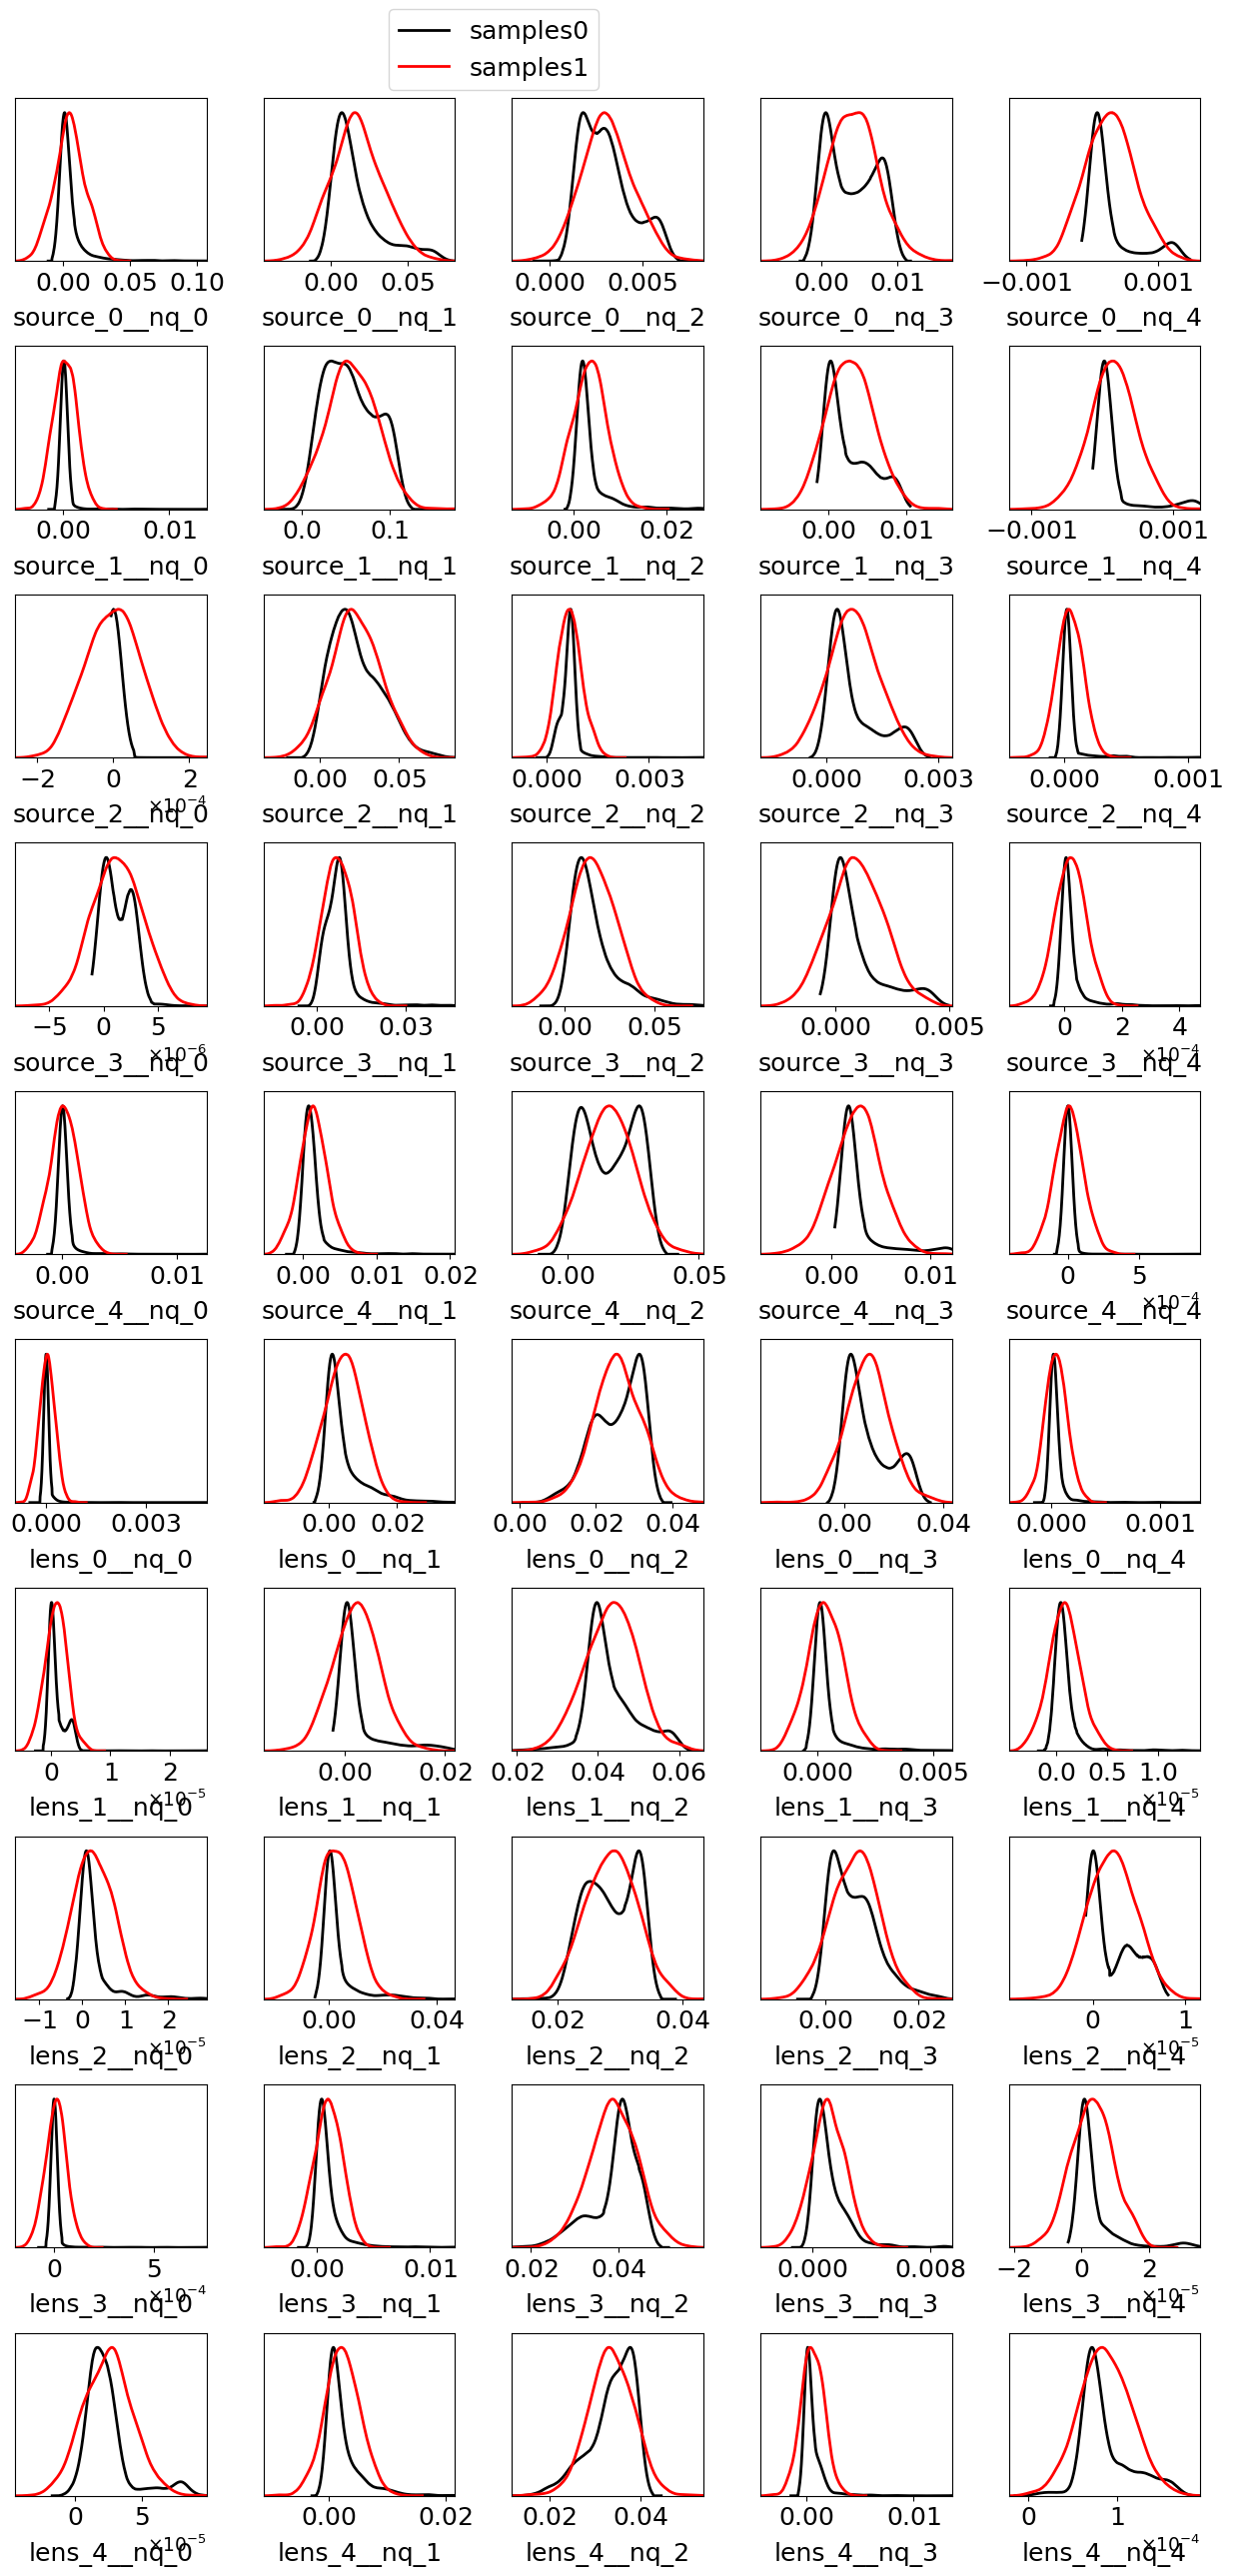

In [35]:
gp_priors.plot_prior(mode="1D", add_prior=True, nx=n, lws=2)

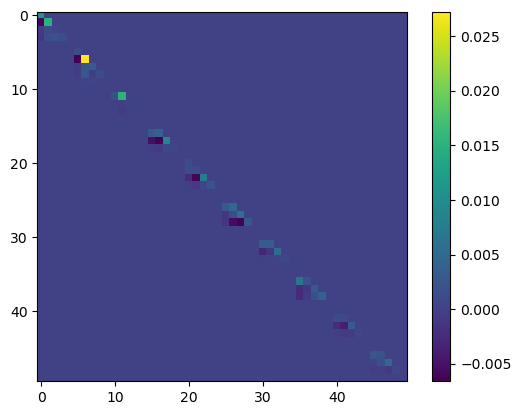

In [36]:
mean, cov, chol = gp_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(chol)
plt.colorbar()

In [37]:
gp_nzs = {}
for i in range(500):
    prior_sample = gp_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = gp_priors.model_objs[tracer_name]
        nz_mean = model_obj.nz_mean
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = np.array([prior_sample[nz_name] for nz_name in nz_names])
        nq = params - model_obj.nq_mean #model_obj.nqs[i]-model_obj.nq_mean
        W = model_obj.W
        nz = nz_mean + np.dot(W, nq)
        z = model_obj.z
        if i == 0:
            gp_nzs[tracer_name] = [z, nz]
        else:
            gp_nzs[tracer_name] = [z, np.vstack([gp_nzs[tracer_name][1], nz])]

In [38]:
_gp_nzs = {}
for i in range(2000):
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = gp_priors.model_objs[tracer_name]
        nz_mean = model_obj.nz_mean
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = model_obj.params.T[i]
        nq = params - model_obj.nq_mean #model_obj.nqs[i]-model_obj.nq_mean
        W = model_obj.W
        nz = nz_mean + np.dot(W, nq)
        z = model_obj.z
        if i == 0:
            _gp_nzs[tracer_name] = [z, nz]
        else:
            _gp_nzs[tracer_name] = [z, np.vstack([gp_nzs[tracer_name][1], nz])]

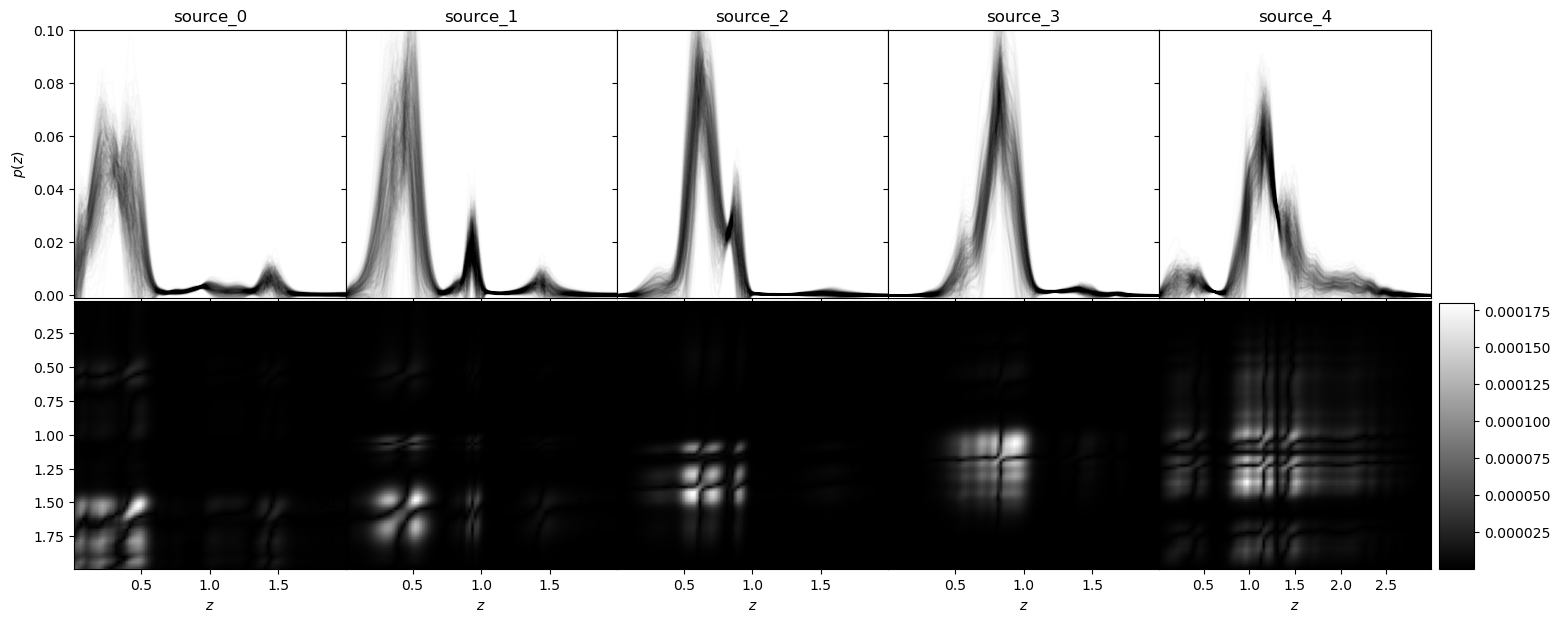

In [39]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(gp_nzs, plot_tracers)

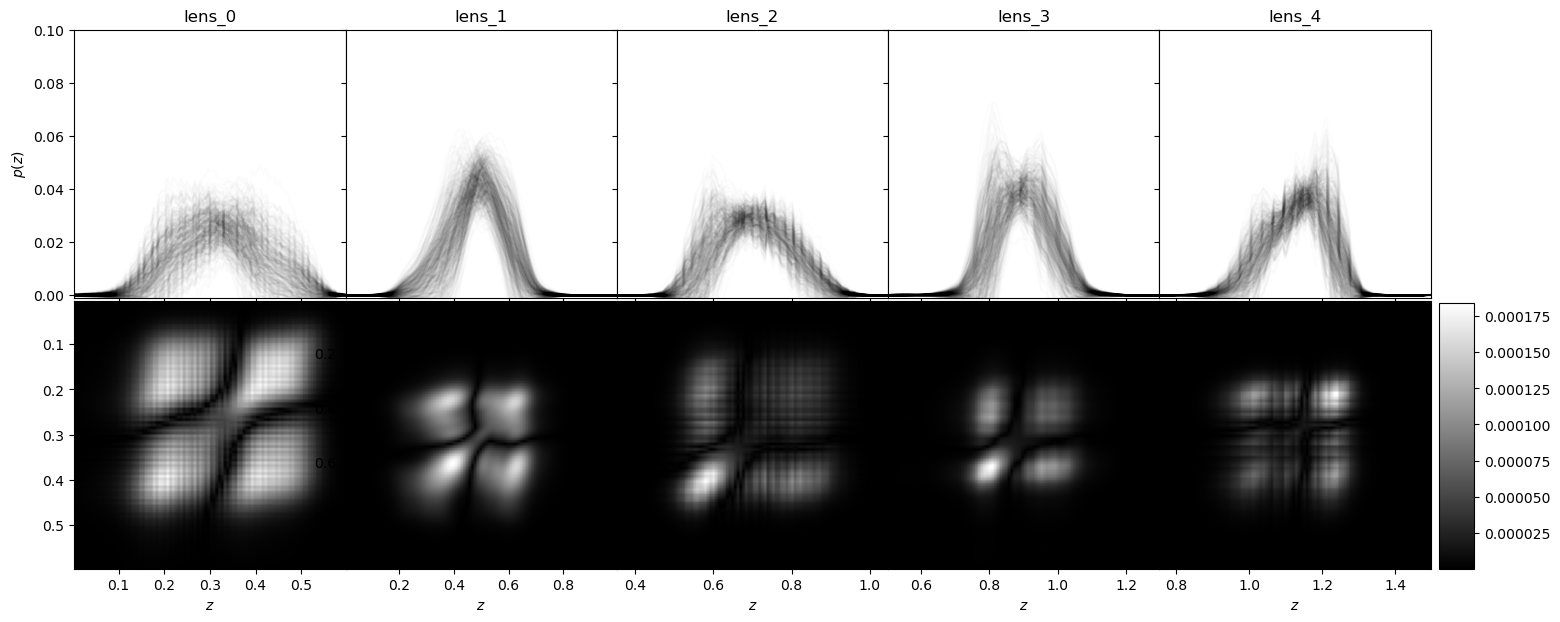

In [40]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(gp_nzs, plot_tracers)

In [41]:
model_objs = gp_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, cov, chol = model_obj.get_prior()
    W = model_obj.W
    print(cov.shape)
    file_name = f"gp_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_gp_{}_priors/".format(method) + file_name
    np.savez(save_to, z=z, mean=mean, cov=cov, chol=chol, W=W)


(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)


In [42]:
gp_var_comp = {}
_gp_var_comp = {}
for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = gp_priors.model_objs[tracer_name]
        shifted_nzs_i = gp_nzs[tracer_name]
        cov = np.cov(shifted_nzs_i[1].T)
        _cov = np.cov(_gp_nzs[tracer_name][1].T)
        __cov = model_obj.nz_cov
        errs = np.sqrt(np.diag(cov))
        _errs = np.sqrt(np.diag(_cov))
        __errs = np.sqrt(np.diag(__cov))
        gp_var_comp[tracer_name] = [shifted_nzs_i[0],  (errs-__errs)/__errs]
        _gp_var_comp[tracer_name] = [shifted_nzs_i[0],  (_errs-__errs)/__errs]

In [43]:
#gp_Ds = {}
#for tracer_name in gp_nzs.keys():
#    model_obj = gp_priors.model_objs[tracer_name]
#    W = model_obj.W
#    nqs = model_obj.nqs - model_obj.nq_mean
#    _nzs = np.array([np.dot(W, nq) for nq in nqs])
#    _nzs += model_obj.nz_mean 
#    mu_2, K_2 = model_obj.nz_mean, model_obj.nz_cov
#    mu_1, K_1 = np.mean(_nzs, axis=0), np.cov(_nzs.T)
#    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
#    gp_Ds[tracer_name] = np.abs(D)

# PCA

In [44]:
n = 5
PCA_priors = nzp.PriorSacc(ss_qp,
                            model="PCA",
                            compute_crosscorrs=crosscorrs_method,
                            npca=n)

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


Removed no burn in
Removed no burn in


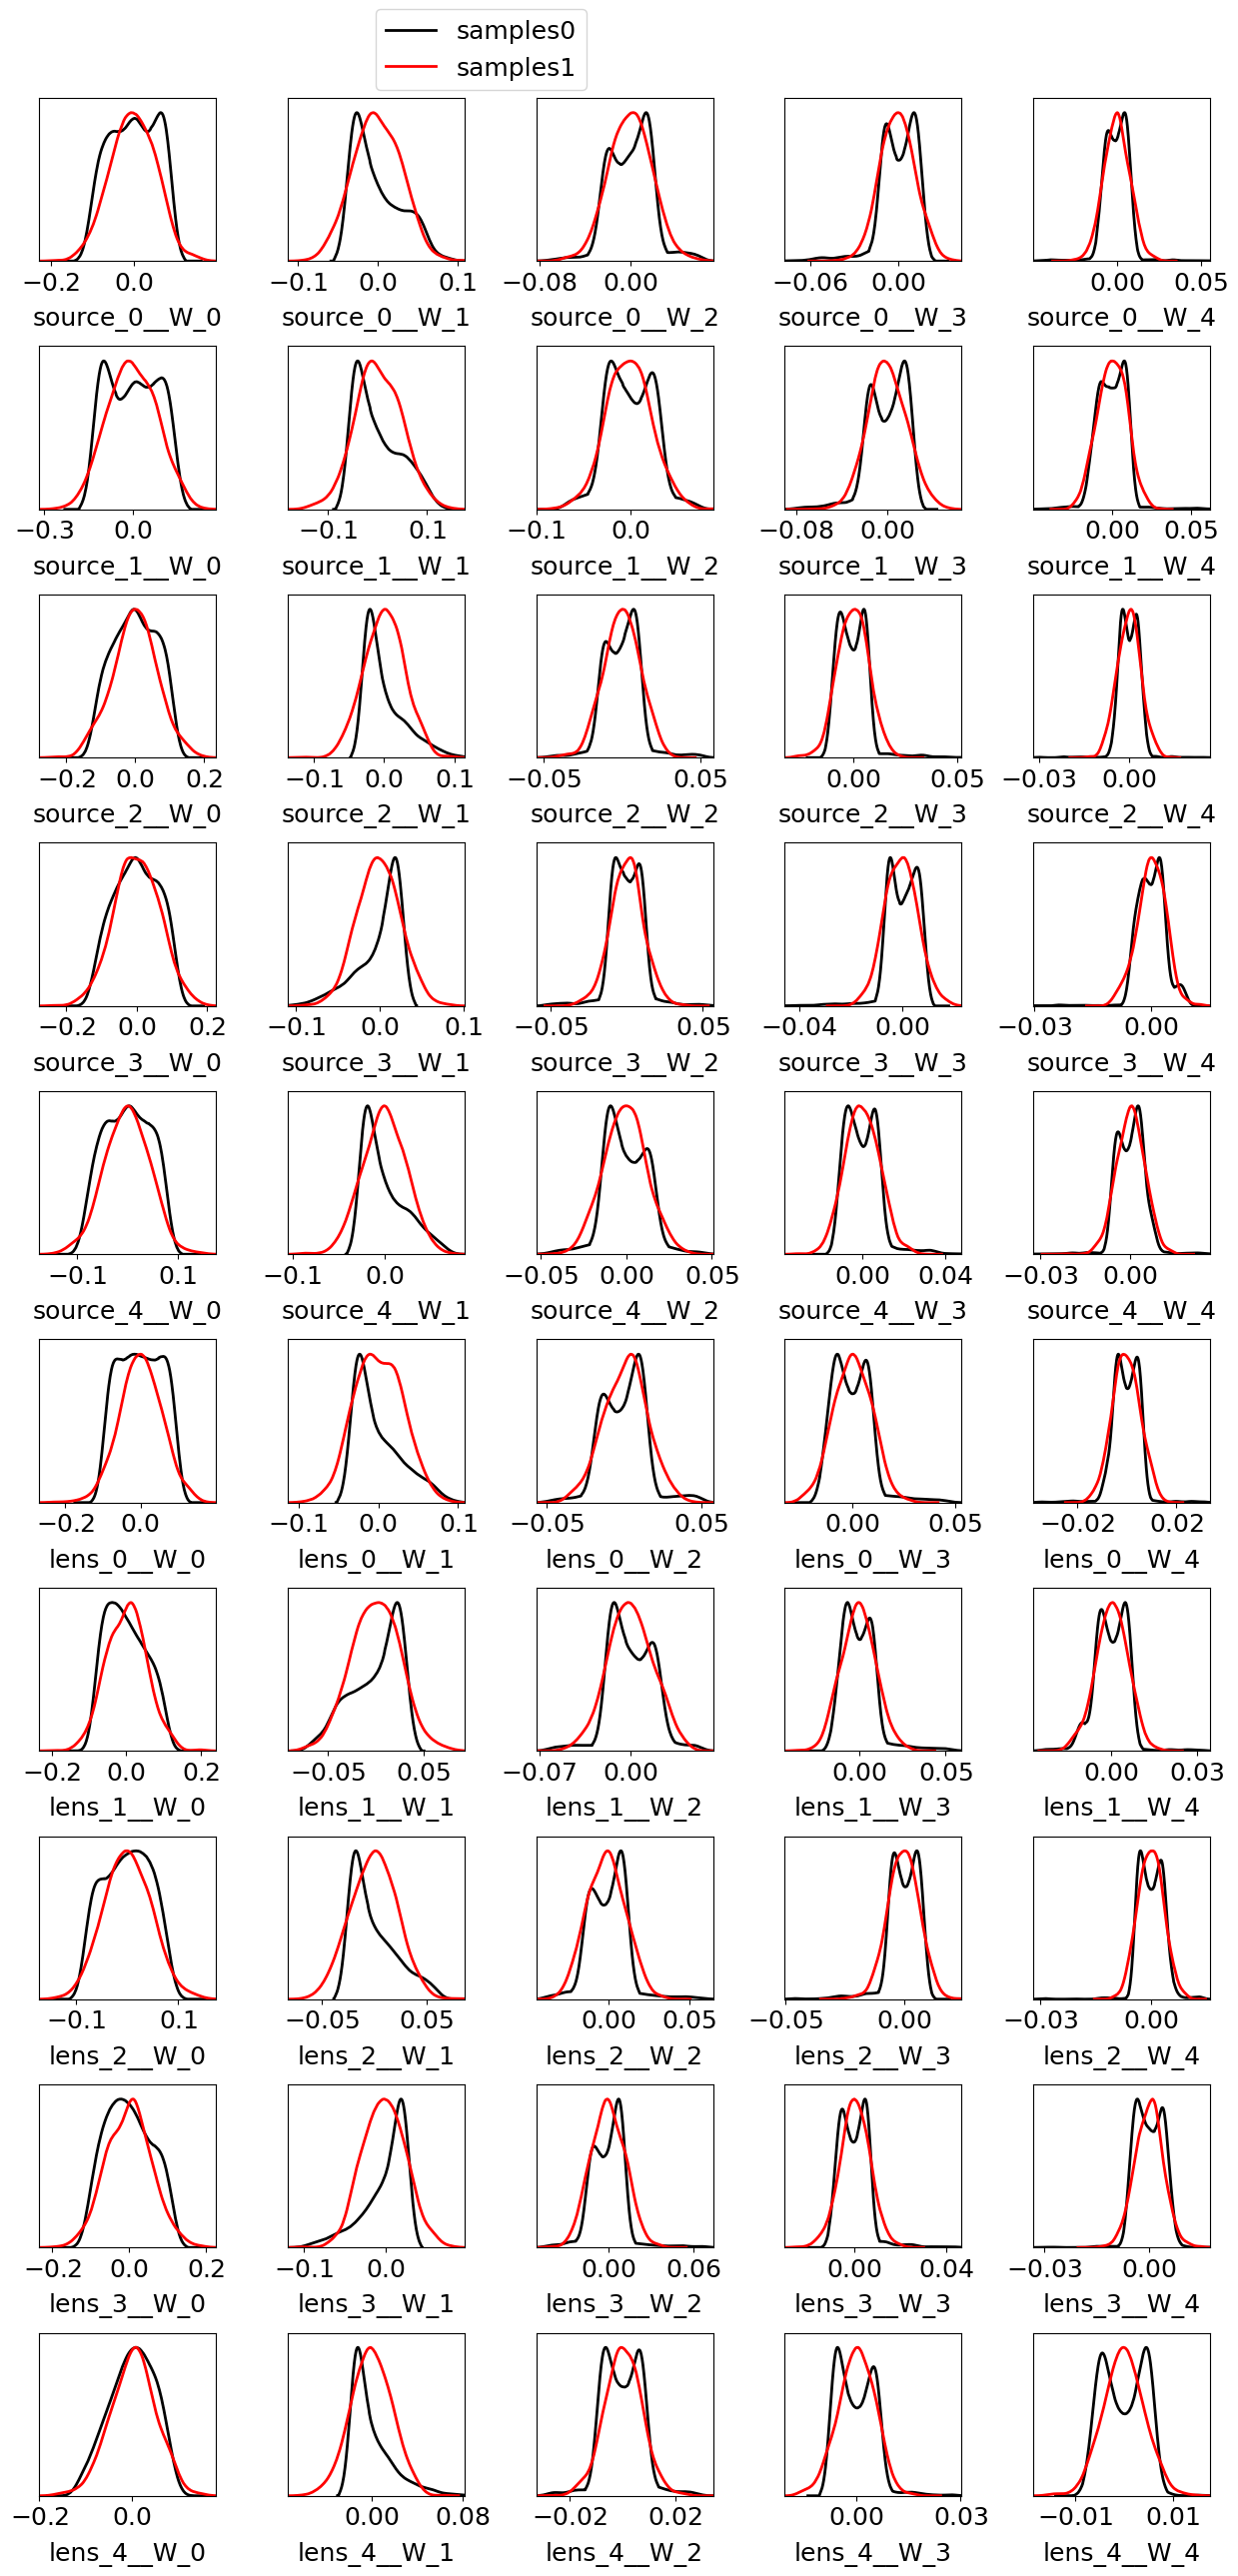

In [45]:
PCA_priors.plot_prior(mode="1D", add_prior=True, nx=5, lws=2)

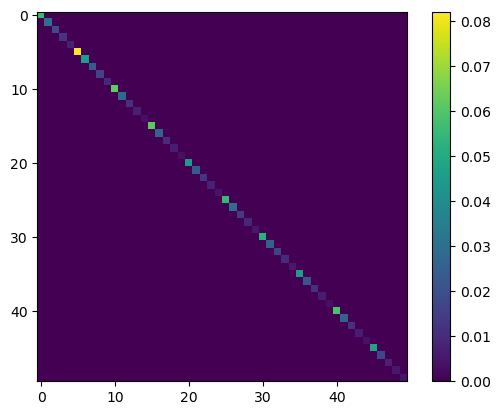

In [46]:
mean, cov, chol = PCA_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(np.sqrt(abs(cov)))
plt.colorbar()

In [47]:
pca_nzs = {}
for i in range(500):
    prior_sample = PCA_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = PCA_priors.model_objs[tracer_name]
        nz_fid = [model_obj.z, model_obj.nz_mean]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = [prior_sample[nz_name] for nz_name in nz_names]
        nz = nzp.pca_model(nz_fid, params, model_obj.eigvecs)[1]
        if i == 0:
            pca_nzs[tracer_name] = [nz_fid[0], nz]
        else:

            pca_nzs[tracer_name] = [nz_fid[0], np.vstack([pca_nzs[tracer_name][1], nz])]

In [48]:
_pca_nzs = {}
for i in range(2000):
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = PCA_priors.model_objs[tracer_name]
        nz_fid = [model_obj.z, model_obj.nz_mean]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = model_obj.params.T[i]
        nz = nzp.pca_model(nz_fid, params, model_obj.eigvecs)[1]
        if i == 0:
            _pca_nzs[tracer_name] = [nz_fid[0], nz]
        else:

            _pca_nzs[tracer_name] = [nz_fid[0], np.vstack([pca_nzs[tracer_name][1], nz])]

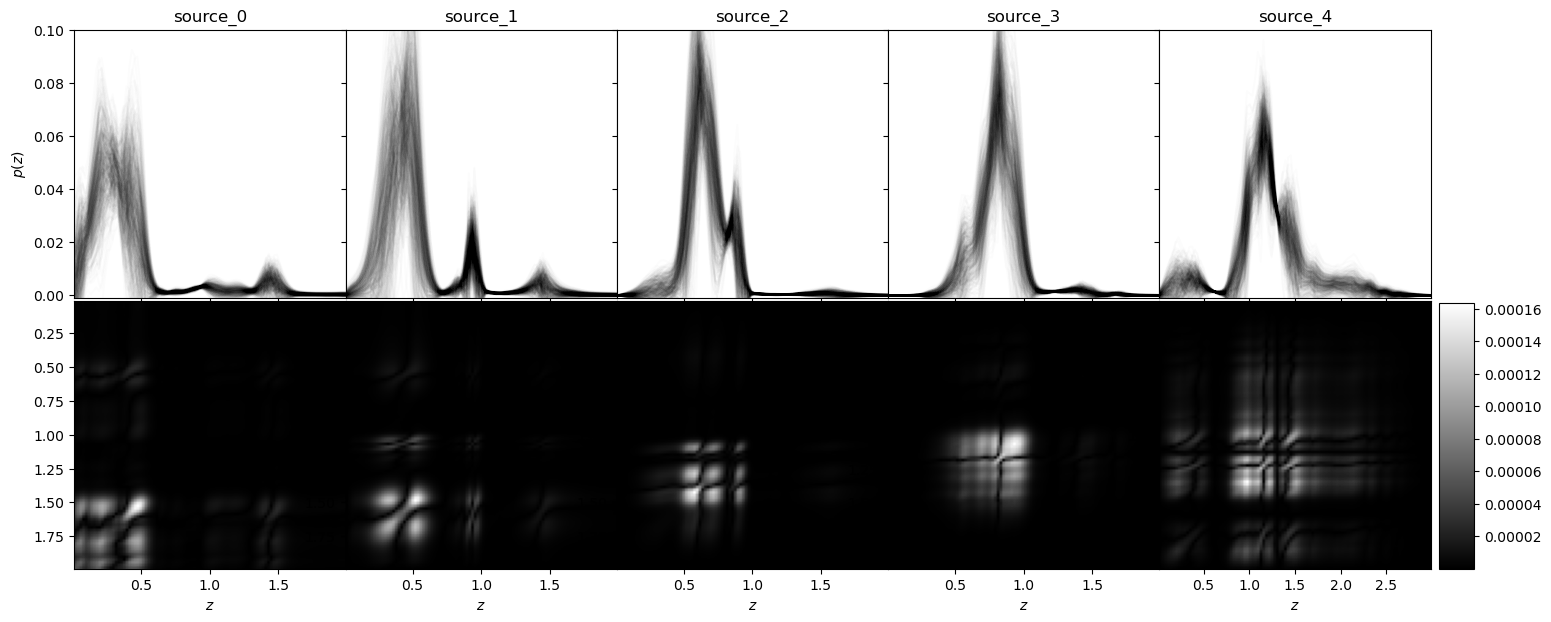

In [49]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(pca_nzs, plot_tracers)

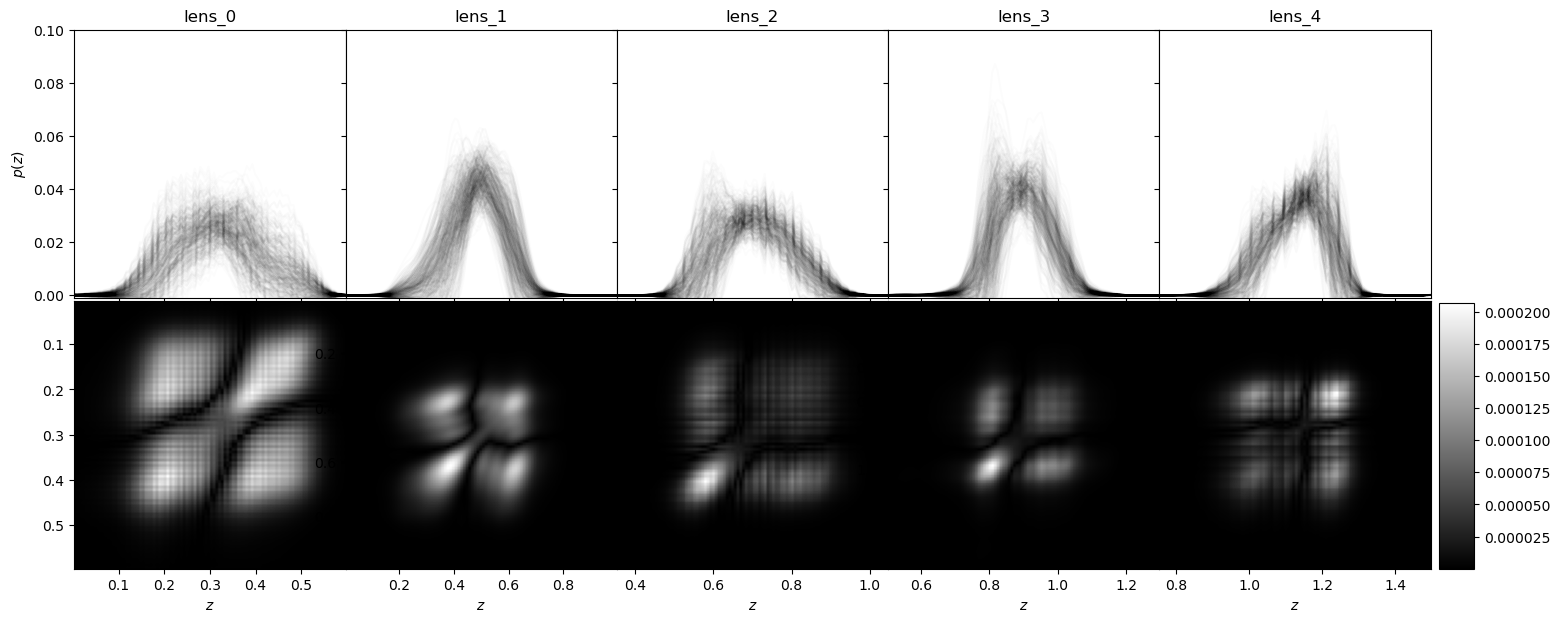

In [50]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(pca_nzs, plot_tracers)

In [51]:
model_objs = PCA_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    eigvecs = model_obj.eigvecs
    mean, cov, chol = model_obj.get_prior()
    file_name = f"PCA_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_PCA_{}_priors/".format(method) + file_name
    np.savez(save_to, z=z, mean=mean, cov=np.sqrt(1000)*cov, chol=np.sqrt(1000)*chol, eigvecs=eigvecs)

In [52]:
pca_var_comp = {}
_pca_var_comp = {}
for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = PCA_priors.model_objs[tracer_name]
        shifted_nzs_i = pca_nzs[tracer_name]
        cov = np.cov(shifted_nzs_i[1].T)
        _cov = np.cov(_pca_nzs[tracer_name][1].T)
        __cov = model_obj.nz_cov
        errs = np.sqrt(np.diag(cov))
        _errs = np.sqrt(np.diag(_cov))
        __errs = np.sqrt(np.diag(__cov))
        pca_var_comp[tracer_name] = [shifted_nzs_i[0],  (errs-__errs)/__errs]
        _pca_var_comp[tracer_name] = [shifted_nzs_i[0],  (_errs-__errs)/__errs]

In [53]:
#pca_Ds = {}
#for tracer_name in pca_nzs.keys():
#    model_obj = PCA_priors.model_objs[tracer_name]
#    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
#    nzs = pca_nzs[tracer_name][1]
#    mu_2 = np.mean(nzs, axis=0)
#    K_2 = np.cov(nzs.T)
#    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
#    pca_Ds[tracer_name] = np.abs(D)

# Comparison

In [115]:
import statistics as stats
def make_var_plots(vars, _vars, tracer_list, labels):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(1, n_tracers, figsize=(n_tracers*7,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    colors = ['blue', 'orange', 'green', 'red']
    for i, key in enumerate(tracer_list):
        for j, var in enumerate(vars):
            zs, _var = var[key]
            zs, __var = _vars[j][key]
            m_err = round(stats.mean(_var), 3)
            _m_err = round(stats.mean(__var), 3)
            axis[i].plot(zs, np.abs(_var), color=colors[j], alpha=0.5, label=f"{labels[j]} - Gaussian {m_err}")
            axis[i].plot(zs, np.abs(__var), color=colors[j], alpha=0.5, linestyle='--', label=f"{labels[j]} - True {_m_err}")
        axis[i].plot(zs, np.zeros_like(zs), 'k--')
        axis[i].set_ylim([0.001, 100])
        #axis[i].set_yscale('symlog', linthresh=0.01, linscale=1)
        axis[i].set_yscale('log')
        axis[i].set_title(key)
        axis[i].set_xlabel('z')
        axis[i].legend(ncol=2)
        if i == 0:
            axis[i].set_ylabel('Relative error')
        else:
            axis[i].set_yticklabels([])
    plt.show()
    return figure

def make_var_plots2(vars, tracer_list, labels):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(1, n_tracers, figsize=(n_tracers*4,4))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        print(key)
        for j, var in enumerate(vars):
            zs, _var = var[key]
            axis[i].fill_between(zs, np.zeros_like(zs), np.abs(_var), label=labels[j], alpha=0.5)
            print(labels[j], round(np.mean(np.abs(_var)), 3))
        print("====")
        axis[i].plot(zs, np.zeros_like(zs), 'k--')
        axis[i].set_ylim([0.001, 10])
        axis[i].set_yscale('log')
        axis[i].set_title(key)
        axis[i].set_xlabel('z')
        axis[i].legend()
        if i == 0:
            axis[i].set_ylabel('Relative error')
        else:
            axis[i].set_yticklabels([])
    plt.show()
    return figure

In [116]:
labels = ['Shifts', 'Shifts & Widths', 'PCA', 'GP',]

In [117]:
vars = [shifts_var_comp, SnWs_var_comp, pca_var_comp, gp_var_comp]
_vars = [_shifts_var_comp, _SnWs_var_comp, _pca_var_comp, _gp_var_comp]

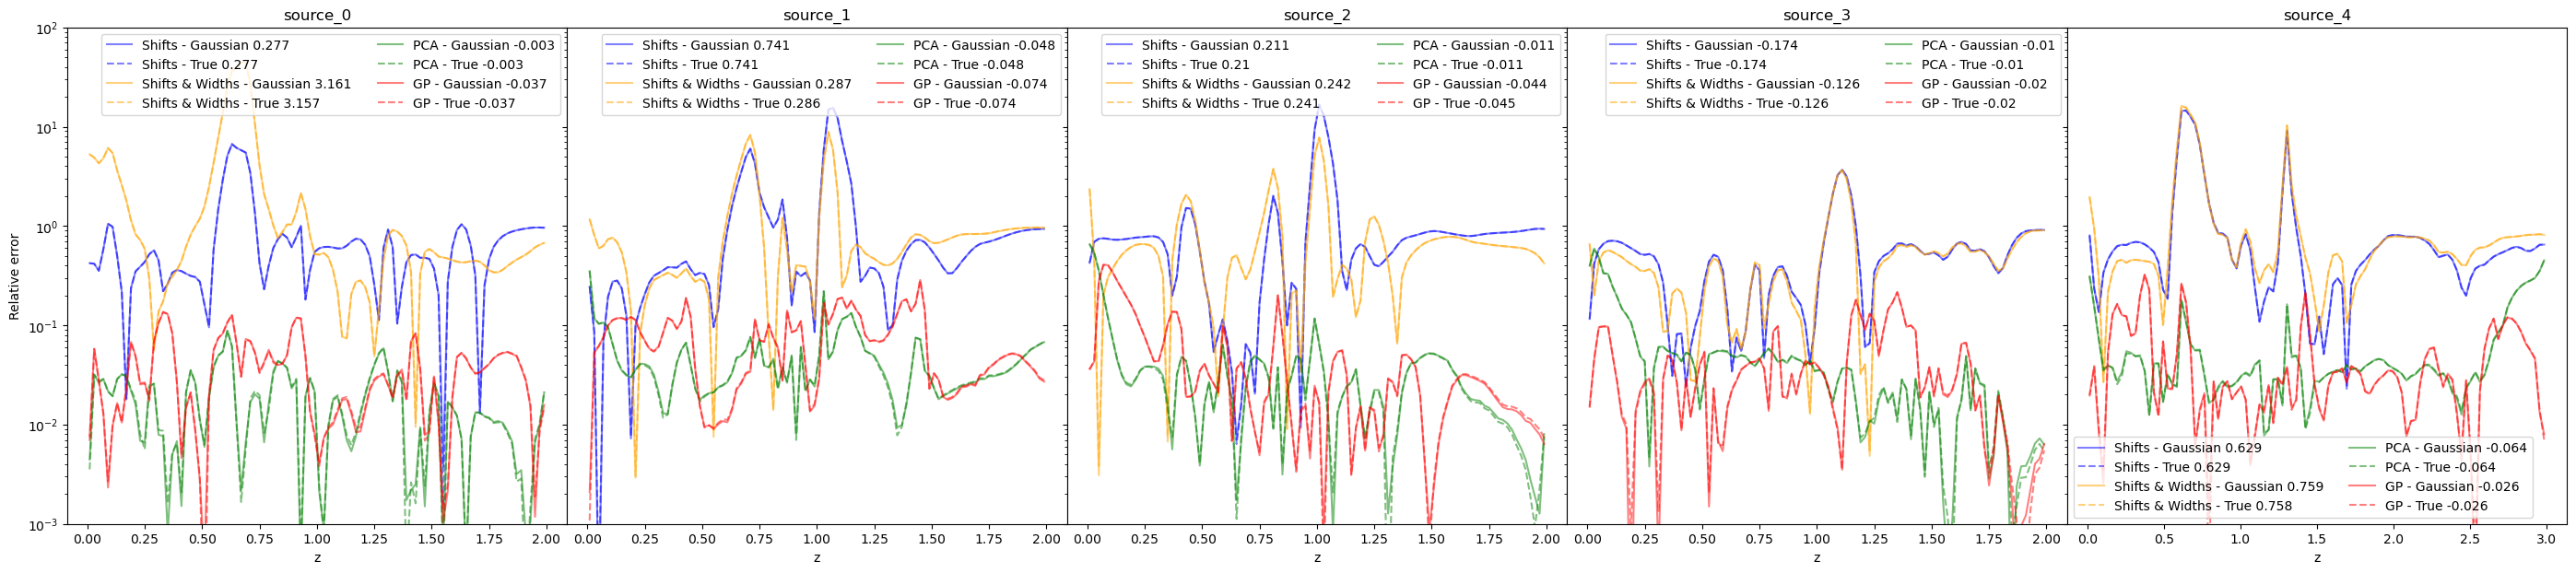

In [118]:
g = make_var_plots(vars, _vars, ['source_0', 'source_1', 'source_2', 'source_3', 'source_4'], labels)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/source_validation.pdf", bbox_inches='tight')

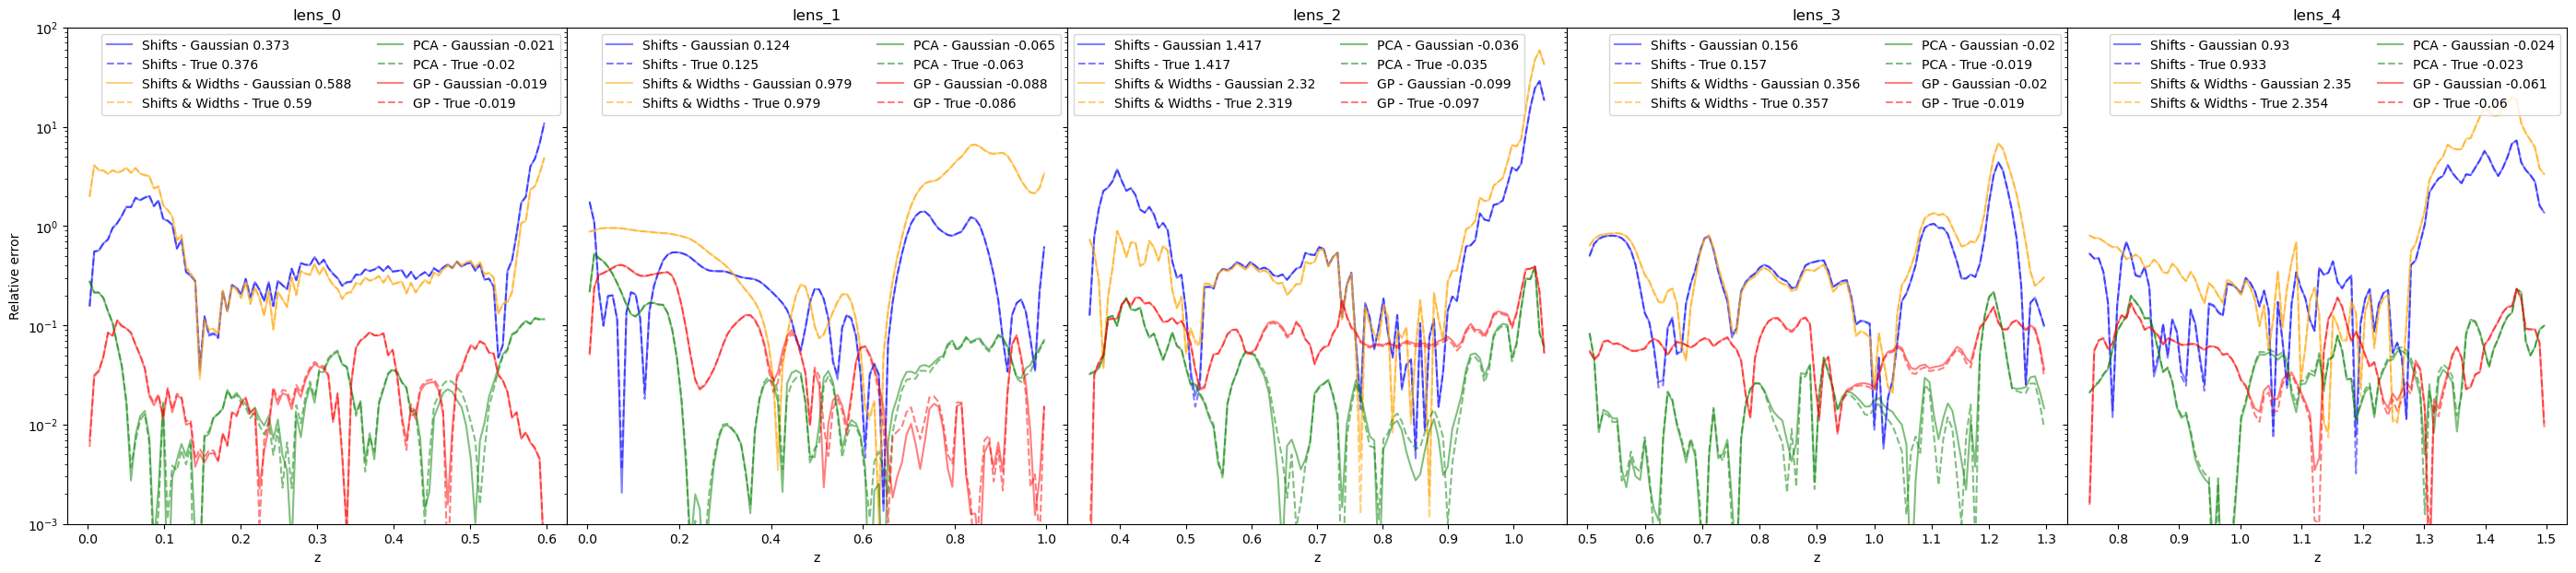

In [119]:
make_var_plots(vars, _vars, ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'], labels)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/lens_validation.pdf", bbox_inches='tight')

In [120]:
def make_D_plots(Ds, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(1, n_tracers, figsize=(n_tracers*3.5,4))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        tracer_Ds = np.log10(1+np.array([D[key] for D in Ds]))
        axis[i].bar(np.arange(len(Ds)), tracer_Ds)
        axis[i].set_xticks(np.arange(4), ['Shifts', 'ShiftsWidths', 'PCA', 'GP'],
                           rotation=45)
        axis[i].set_title(key)
        if i == 0:
            axis[i].set_ylabel(r'$\log ((1/2)*[D_{KL}(f|g)+D_{KL}(g|f)])$')
        else:
            axis[i].set_yticklabels([])
    plt.show()